In [1]:
import tweepy
import datetime

import re
import string
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize

from nltk.stem import WordNetLemmatizer

import nltk
nltk.download("stopwords")
nltk.download('punkt')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soheilhosseini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/soheilhosseini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
tweepy.__version__

'4.0.0-alpha'

In [3]:
# API key
consumer_key = "***"
consumer_secret = "***"

In [4]:
access_token = "***"
access_token_secret = "***"

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [7]:
query = "#globalwarming"

status = tweepy.Cursor(api.search_tweets,  q=query, count=1000, lang ="en").pages(10)


In [8]:
status

In [9]:
created_at = []
tweets_org = []
for i in status:
    for j in range(len(i)):
        created_at.append(i[j]._json['created_at']) 
        tweets_org.append(i[j].text)



In [10]:
tweets_org[3]


'RT @OfficialMBTM: Carol hath spoken...\n\nMore here https://t.co/QwdtxBeYXU\n\n#caroldecker #tpau #musiclegend #climatechange #savetheplanet #g…'

In [11]:
stopwords_en  = stopwords.words('english')

In [12]:
tt = TweetTokenizer()


In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
lemmatizer.lemmatize(tweets_org[0])

'RT @SCVIndy: @BeeAsMarine Interestingly it’s us that has solution to #climatechange in that each individual’s consumption nonrenewable #Fos…'

In [15]:
last_time = max(created_at)
first_time = min(created_at)

In [16]:
time_tweeted = pd.DataFrame(created_at, columns = ['date'])
time_tweeted ['date'] = time_tweeted ['date'].astype('datetime64[ns]')

time_tweeted.head()

,date
0,2021-12-11 21:37:32
1,2021-12-11 21:37:19
2,2021-12-11 21:35:53
3,2021-12-11 21:31:19
4,2021-12-11 21:31:19


In [17]:
time_tweeted['month_day'] = pd.to_datetime(time_tweeted.date).dt.strftime('%b %d, %Y')
time_tweeted['hour'] = pd.to_datetime(time_tweeted.date).dt.strftime('%H')


In [18]:
time_tweeted.head()

,date,month_day,hour
0,2021-12-11 21:37:32,"Dec 11, 2021",21
1,2021-12-11 21:37:19,"Dec 11, 2021",21
2,2021-12-11 21:35:53,"Dec 11, 2021",21
3,2021-12-11 21:31:19,"Dec 11, 2021",21
4,2021-12-11 21:31:19,"Dec 11, 2021",21


In [19]:
tweet_per_day_time = time_tweeted.groupby(['month_day', 'hour']).count()


<AxesSubplot:xlabel='month_day,hour'>

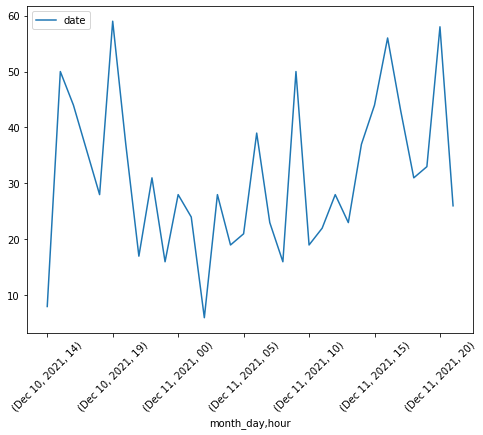

In [20]:
tweet_per_day_time.plot(figsize=(8,6),rot=45)

tweet_per_day_time.unstack(level=0).plot(figsize =(10,6), linewidth = 3)
plt.xticks()
plt.title("Number of tweets per hour")
plt.xlabel("hour")
plt.show()

Estimating Sentiment Score
There are many resources describing methods to estimate sentiment. For the purpose of this tutorial, we will use a very simple algorithm which assigns sentiment score of the text by simply counting the number of occurrences of “positive” and “negative” words in a tweet.

Hu & Liu have published an “Opinion Lexicon” that categorizes approximately 6,800 words as positive or negative, which can be downloaded from this link:

http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [21]:
positive = pd.read_csv('opinion-lexicon-English/positive-words.txt',skiprows= range(29), names =['positive_words'])
positive.head()

,positive_words
0,a+
1,abound
2,abounds
3,abundance
4,abundant


In [22]:
negative = pd.read_csv('opinion-lexicon-English/negative-words.txt',skiprows= range(30), names =['negative_words'])
negative.head()

,negative_words
0,2-faced
1,2-faces
2,abnormal
3,abolish
4,abominable


In [23]:
#convert positive and negative dataframes to list
positive_list = positive['positive_words'].values.tolist()
positive_list.append(['upgrade','Congrats','prizes','prize','thanks','thnx',
              'Grt','gr8','plz','trending','recovering','brainstorm','leader'])

negative_list = negative['negative_words'].values.tolist()
negative_list.append(['wtf','wait','waiting','epicfail','Fight','fighting',
              'arrest','no','not'])


In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("max_colwidth", None)

In [25]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    
    # Convert to lowercase
    tweet_cleaned = tweet.lower()
    
    # Tokenize the tweet  
    tweets_list = [word for word in tt.tokenize(tweet_cleaned) if word not in stopwords_en]
    
    tweets_list = list(map(lemmatizer.lemmatize, tweets_list))
    
    # Convert list to string
    tweet_cleaned = " ".join(tweets_list)

    # remove old style retweet text "RT"
    tweet_cleaned = re.sub(r'^rt[\s]+', ' ', tweet_cleaned)
    

    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet_cleaned = re.sub(r'#', '', tweet_cleaned)

    #remove at @
    tweet_cleaned = re.sub(r'@\w*\W*', ' ', tweet_cleaned)

    # Remove numbers
#    tweet_cleaned = re.sub(r'\s\d+', ' ', tweet_cleaned)
    tweet_cleaned = re.sub(r'\s*\w*\d+\w*', ' ', tweet_cleaned)
        
    ####
    # remove hyperlinks
    tweet_cleaned = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet_cleaned)
    
    
        #Remove non-ascii 
    tweet_cleaned = re.sub(r'[^\x00-\x7F]', ' ', tweet_cleaned)
    

    # Remove non-word character (also punctuations)
    tweet_cleaned = re.sub(r'\s*\W+', ' ', tweet_cleaned)

    # remove blank spaces at the beginning and end
    tweet_cleaned = re.sub(r'^ * | *$', '', tweet_cleaned)   
    
    return tweet_cleaned

In [26]:
tweets_org[0:10]

['RT @SCVIndy: @BeeAsMarine Interestingly it’s us that has solution to #climatechange in that each individual’s consumption nonrenewable #Fos…',
 'The Communist Party of the USA https://t.co/9wwhIQUH9a\ncan fill you in on all the latest news on the Kellogg’s stri… https://t.co/FsGgpLHN6z',
 'RT @fartsaucier: Did y’all know that the manatees around FL are ALL starving to death (100’s/week) because the sea grass they eat is dead d…',
 'RT @OfficialMBTM: Carol hath spoken...\n\nMore here https://t.co/QwdtxBeYXU\n\n#caroldecker #tpau #musiclegend #climatechange #savetheplanet #g…',
 'RT @OfficialMBTM: Me too brother...\n\nMore here https://t.co/QwdtxBeYXU\n\n#peterbeckett #player #globalwarming #climatechange #climatecrisis…',
 'RT @OfficialMBTM: Me too brother...\n\nMore here https://t.co/QwdtxBeYXU\n\n#peterbeckett #player #globalwarming #climatechange #climatecrisis…',
 'RT @OfficialMBTM: Carol hath spoken...\n\nMore here https://t.co/QwdtxBeYXU\n\n#caroldecker #tpau #musiclegend #clima

In [27]:
tweets_cleaned = list(map(process_tweet, tweets_org))
tweets_cleaned[0:10]

['beeasmarine interestingly u solution climatechange individual consumption nonrenewable fos',
 'communist party usa',
 'know manatee around fl starving death week sea grass eat dead',
 'carol hath spoken',
 'brother',
 'brother',
 'carol hath spoken',
 'talk biggest offender pollution china creating globalwarming',
 'saying tornado outbreak god s judgment get fucking dark age science li',
 'know manatee around fl starving death week sea grass eat']

In [28]:
# Convert list to DataFrame
tweets_df = pd.DataFrame(tweets_cleaned)
tweets_df.head()

,0
0,beeasmarine interestingly u solution climatechange individual consumption nonrenewable fos
1,communist party usa
2,know manatee around fl starving death week sea grass eat dead
3,carol hath spoken
4,brother


In [30]:
# length of each tweet
tweets_df.apply(lambda x: len(x.values[0]), axis=1).head()

0    90
1    19
2    61
3    17
4     7
dtype: int64

In [31]:
# Going through each tweet, if there is a match in positive list replace with True, or 
# if there is a match in negative list replace with True

In [32]:
pos_score = []
# Replace every element matched with pos list with True, repalce NaN with 0
# add values for each index, save it in numpy array
for j in range(len(tweets_cleaned)):
    
    text_split_score = [True if i in positive_list else np.nan for i in tweets_cleaned[j].split()]
    text_split_score = [0 if np.isnan(x) else x for x in text_split_score]
    pos_score.append(text_split_score)      


pos_array = np.array([])
for i in pos_score:
    pos_array = np.append(pos_array, sum(i))


In [33]:
neg_score = []
# Replace every element matched with negative list with True, repalce NaN with 0
# add values for each index, save it in numpy array
for j in range(len(tweets_cleaned)):
    
    text_split_score = [True if i in negative_list else np.nan for i in tweets_cleaned[j].split()]
    text_split_score = [0 if np.isnan(x) else x for x in text_split_score]
    neg_score.append(text_split_score)      
#print(pos_score)


neg_array = np.array([])
for i in neg_score:
    neg_array = np.append(neg_array, sum(i))


In [34]:
# Subtracting postive score from negative score to find out about sentiment analysis of each tweet
score_arr = pos_array - neg_array


In [35]:
score_df = pd.DataFrame(score_arr, columns=['score'])
score_df.head()

,score
0,0.0
1,0.0
2,-2.0
3,0.0
4,0.0


In [36]:
# Convert score type from float to integer
score_df['score'] = score_df['score'].astype('int')
score_df.head()

,score
0,0
1,0
2,-2
3,0
4,0


In [37]:
# Frequecy of scores
score_df['score'].value_counts()

 0    457
 1    245
-1    150
-2     68
 2     68
-3      6
 3      6
Name: score, dtype: int64

## Histogram of sentiment scores:

(array([  6.,  68., 150., 457., 245.,  74.]),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 6 artists>)

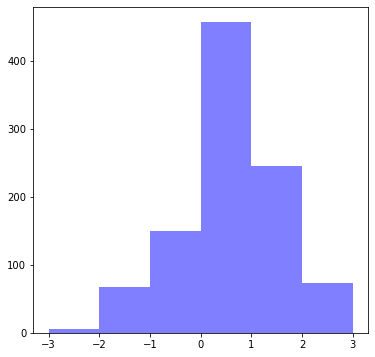

In [38]:
plt.figure(figsize=(6,6))
plt.hist(score_df,bins=6, color='b', alpha=0.5)

In [39]:
# categorize score values to types (neutral, positive, and negative)
score_df['type'] = np.where(score_df['score'] == 0, 'neutral', 
                            np.where(score_df['score'] >  0, 'positive', 
                                                np.where(score_df['score'] <  0, 'negative',np.nan))) 
    
score_df.head()

,score,type
0,0,neutral
1,0,neutral
2,-2,negative
3,0,neutral
4,0,neutral


In [40]:
# Frequecy of tweet types
score_df['type'].value_counts()

neutral     457
positive    319
negative    224
Name: type, dtype: int64

<AxesSubplot:title={'center':'Barplot of sentiment type'}, xlabel='Sentiment', ylabel='Count'>

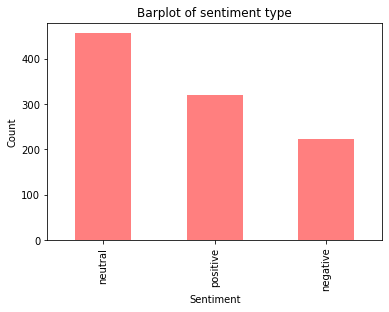

In [41]:
# Barplot of sentiment type:

score_df['type'].value_counts().plot(kind='bar', title ='Barplot of sentiment type', 
                                     xlabel='Sentiment', ylabel = 'Count', color='r', alpha =0.5)